Representations:
* Individual tree
* Trajectory
    * Radii vs. iteration, with summaries such as log-probability, and the marginal likelihoods of various models
    * Include SMIRKS tags for the individual types

In [1]:
from pickle import load
from glob import glob
fnames = glob('../bayes_implicit_solvent/rjmc_experiments/bugfixed_*gaussian_ll.pkl')
print(fnames)

['../bayes_implicit_solvent/rjmc_experiments/bugfixed_tree_rjmc_run_n_compounds=321_n_iter=1000_gaussian_ll.pkl']


In [2]:
with open(fnames[0], 'rb') as f:
    result = load(f)

In [3]:
result.keys()

dict_keys(['traj', 'log_probs', 'log_acceptance_probabilities'])

In [4]:
traj = result['traj']
log_probs = result['log_probs']
log_acceptance_probabilities = result['log_acceptance_probabilities']

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'log probability')

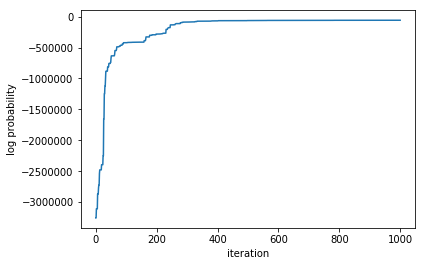

In [6]:
plt.plot(log_probs)
plt.xlabel('iteration')
plt.ylabel('log probability')

Text(0, 0.5, 'log probability')

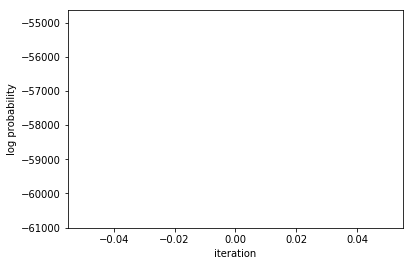

In [7]:
plt.plot(log_probs[1000:])
plt.xlabel('iteration')
plt.ylabel('log probability')

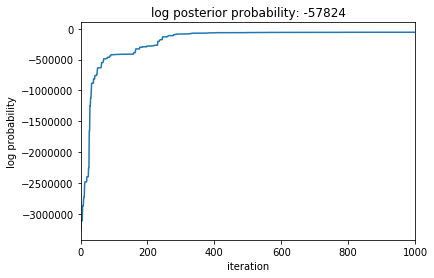

In [8]:
import numpy as np
def plot_log_prob(t=1000, include_number=True):
    
    plt.xlim(0, len(log_probs))
    
    #min_t = max(0,t - 500)
    #plt.ylim(log_probs[0], max(log_probs) + np.abs(max(log_probs) * 0.01))
    plt.plot(log_probs[:t])
    plt.xlabel('iteration')
    plt.ylabel('log probability')
    title = 'log posterior probability'
    if include_number:
        title += ': {}'.format(int(log_probs[t]))
    plt.title(title)
plot_log_prob(t=len(log_probs) - 1)

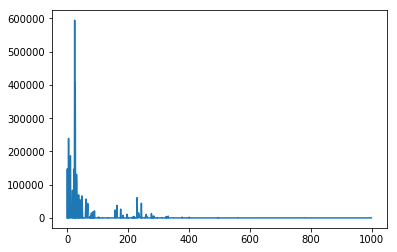

In [9]:
plt.plot(np.diff(log_probs))

In [10]:
np.sum(np.diff(log_probs)<0)

49

In [11]:
tree = traj[0]

Text(0.5, 0, 'iteration')

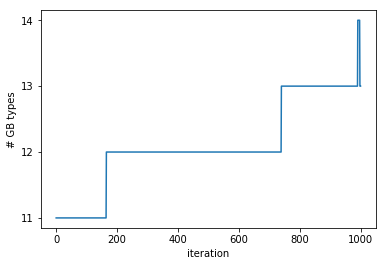

In [12]:
n_types = [tree.number_of_nodes for tree in traj]
plt.plot(n_types)
plt.yticks(list(range(min(n_types), max(n_types) + 1)))
plt.ylabel('# GB types')
plt.xlabel('iteration')

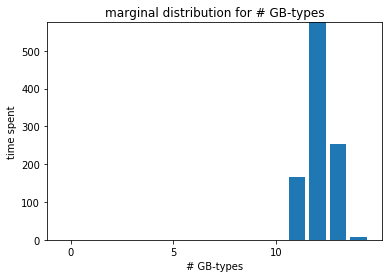

In [13]:
import numpy as np


def plot_running_average_model_evidence(t=1000):
    x = list(range(0, max(n_types) + 1))
    y = np.bincount(n_types[:t], minlength=len(x))
    
    plt.bar(x, y)
    plt.xlabel('# GB-types')
    plt.ylabel('time spent')
    plt.title('marginal distribution for # GB-types')
    
    plt.xticks(list(range(max(n_types) + 1))[::5])
    
    plt.ylim(0,max(np.bincount(n_types)))
plot_running_average_model_evidence()

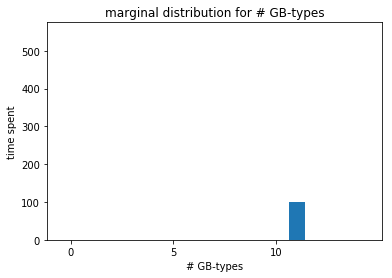

In [14]:
plot_running_average_model_evidence(100)

In [15]:
tree = traj[-1]

In [16]:
from simtk import unit

radii = np.array([tree.get_radius(n) / unit.nanometer for n in tree.nodes])

In [17]:
list(zip(tree.nodes, radii))

[('*', 0.0888679349463488),
 ('[#1]', 0.14127686376500884),
 ('[#6]', 0.21050473696135738),
 ('[#7]', 0.14143931544077798),
 ('[#8]', 0.12233964655420357),
 ('[#9]', 0.1688405166385057),
 ('[#15]', 0.07187564454887115),
 ('[#16]', 0.18685279140508496),
 ('[#17]', 0.03642536840928004),
 ('[#35]', 0.15200415278274862),
 ('[#53]', 0.1554476383130058),
 ('[#7]~[#6]', 0.21279396658609517),
 ('[#16]~[#17]', 0.20648497504685379)]

In [18]:
# to assign colors, let's get all of the types every encountered during the simulation
# then put them in lexicographic order, then make a dictionary that indexes into a nice seaborn color palette

In [19]:
all_types = set()
for tree in traj:
    all_types.update(tree.nodes)
all_types = sorted(list(all_types))

In [20]:
all_types

['*',
 '[#15]',
 '[#16]',
 '[#16]~[#17]',
 '[#17]',
 '[#1]',
 '[#35]',
 '[#53]',
 '[#6]',
 '[#7]',
 '[#7]~[#6]',
 '[#7]~[#6]~[#16]',
 '[#8]',
 '[#9]']

In [21]:
len(all_types)

14

In [22]:
import seaborn.apionly as sns
color_list = sns.color_palette(palette="husl", n_colors=len(all_types))
color_list = color_list[5:] + color_list[:5]
color_dict = dict(zip(all_types, color_list))

/Users/joshuafass/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/joshuafass/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/joshuafass/anaconda3/lib/python3.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [155]:
# for scatter plot representation
x = []
y = []
c = []

for i in range(len(traj)):
    tree = traj[i]
    radii = [tree.get_radius(n) / unit.nanometer for n in tree.nodes]
    
    x += [i] * len(radii)
    y += radii
    c += [color_dict[t] for t in tree.nodes]

In [156]:
# for line-plot representation
x = np.arange(len(traj))
ys = [np.zeros(len(traj)) * np.nan for _ in all_types]
c = [color_dict[t] for t in all_types]

type_dict = dict(zip(all_types, range(len(all_types))))

for time, tree in enumerate(traj):
    for n in tree.nodes:
        i = type_dict[n]
        ys[i][time] = tree.get_radius(n) / unit.nanometer

In [25]:
print(traj[0])
print(traj[-1])

*          (r = 0.1 nm)
|-[#1]     (r = 0.1 nm)
|-[#6]     (r = 0.1 nm)
|-[#7]     (r = 0.1 nm)
|-[#8]     (r = 0.1 nm)
|-[#9]     (r = 0.1 nm)
|-[#15]    (r = 0.1 nm)
|-[#16]    (r = 0.1 nm)
|-[#17]    (r = 0.1 nm)
|-[#35]    (r = 0.1 nm)
|-[#53]    (r = 0.1 nm)
*                  (r = 0.088 nm)
|-[#1]             (r = 0.141 nm)
|-[#6]             (r = 0.210 nm)
|-[#7]             (r = 0.141 nm)
  |-[#7]~[#6]      (r = 0.212 nm)
|-[#8]             (r = 0.122 nm)
|-[#9]             (r = 0.168 nm)
|-[#15]            (r = 0.071 nm)
|-[#16]            (r = 0.186 nm)
  |-[#16]~[#17]    (r = 0.206 nm)
|-[#17]            (r = 0.036 nm)
|-[#35]            (r = 0.152 nm)
|-[#53]            (r = 0.155 nm)


In [26]:
ys[0] - ys[1]

array([0.        , 0.        , 0.        , ..., 0.01699229, 0.01699229,
       0.01699229])

In [27]:
tree.nodes

['*',
 '[#1]',
 '[#6]',
 '[#7]',
 '[#8]',
 '[#9]',
 '[#15]',
 '[#16]',
 '[#17]',
 '[#35]',
 '[#53]',
 '[#7]~[#6]',
 '[#16]~[#17]']

In [28]:
tree.get_radius('*'), tree.get_radius('[#1]')

(Quantity(value=0.0888679349463488, unit=nanometer),
 Quantity(value=0.14127686376500884, unit=nanometer))

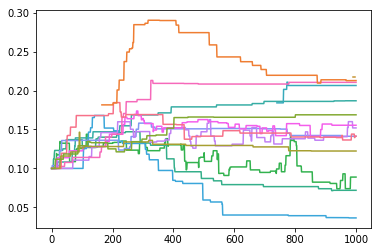

In [29]:
for i in range(len(all_types)):
    plt.plot(x, ys[i], c=c[i])

In [30]:
for y, n in zip(ys, all_types):
    if np.min(y) < 0:
        print(n)

/Users/joshuafass/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [31]:
[(n, np.min(np.nan_to_num(y))) for (n, y) in zip(all_types, ys)]

[('*', 0.07381052866624924),
 ('[#15]', 0.07145526391757363),
 ('[#16]', 0.1),
 ('[#16]~[#17]', 0.0),
 ('[#17]', 0.03642536840928004),
 ('[#1]', 0.1),
 ('[#35]', 0.1),
 ('[#53]', 0.1),
 ('[#6]', 0.1),
 ('[#7]', 0.1),
 ('[#7]~[#6]', 0.0),
 ('[#7]~[#6]~[#16]', 0.0),
 ('[#8]', 0.1),
 ('[#9]', 0.1)]

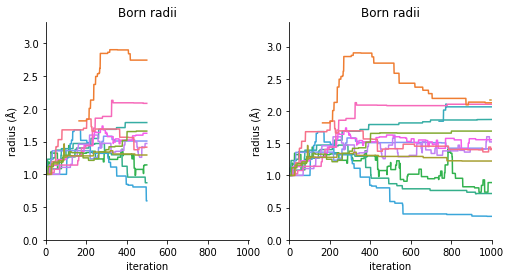

In [160]:
def plot_radii_as_scatter(ax, up_to_iteration=1000):
    
    t = np.argmax(np.array(x) >= up_to_iteration)
    
    ax.scatter(x[:t], y[:t], s=1, color=c[:t])
    ax.set_xlim(0, len(traj))
    ax.set_ylim(0, max(y) * 1.1)
    ax.set_xlabel('iteration')
    ax.set_ylabel('radius (Å)')
    
    ax.set_title('Born radii')
    
def plot_radii(ax, up_to_iteration=1000):
    max_y = -np.inf
    
    for i in range(len(all_types)):
        y = ys[i][:up_to_iteration] * 10
        ax.plot(x[:up_to_iteration], y, c=c[i])
        max_y = max(max(y), max_y)
    ax.set_xlim(0, len(traj))
    ax.set_ylim(0, max_y * 2)
    ax.set_xlabel('iteration')
    ax.set_ylabel('radius (Å)')
    
    ax.set_title('Born radii')

def prettify_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plot_radii(ax, 500)
prettify_axes(ax)

ax = plt.subplot(1,2,2)
plot_radii(ax)
prettify_axes(ax)

In [33]:
node_color = [color_dict[n] for n in tree.G.nodes()]
import networkx as nx

In [34]:
layouts = [
    ('shell', nx.layout.shell_layout(tree.G)),
    ('fruchterman_reingold', nx.layout.fruchterman_reingold_layout(tree.G)),
    ('kamada_kawai', nx.layout.kamada_kawai_layout(tree.G)),
    ('spectral', nx.layout.spectral_layout(tree.G)),
    ('circular', nx.layout.circular_layout(tree.G)),
]

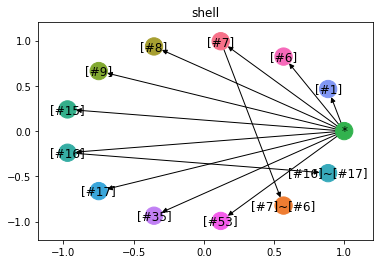

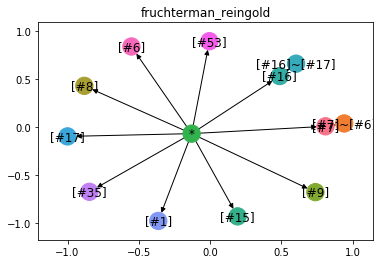

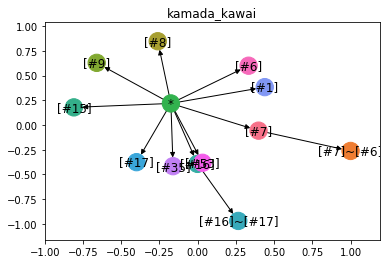

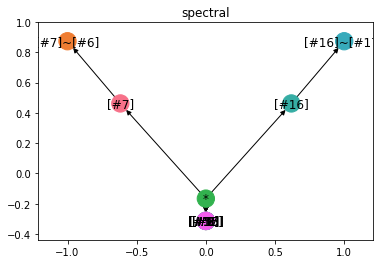

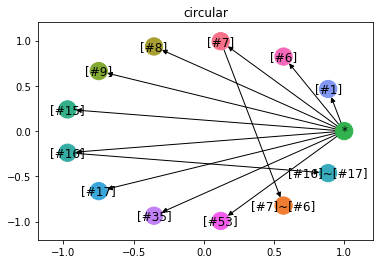

In [35]:
for name, pos in layouts:
    plt.figure()
    plt.title(name)
    nx.draw_networkx(tree.G, pos=pos, node_color=node_color, )

In [36]:
# none of these are what I want!

In [37]:
# let's just precompute sensible positions for all of the types

In [38]:
def depth(node):
    if node == '*':
        return 0
    return len(node.split('~'))

In [39]:
depth_dict = dict(zip(all_types, map(depth, all_types)))

In [40]:
depth_dict

{'*': 0,
 '[#15]': 1,
 '[#16]': 1,
 '[#16]~[#17]': 2,
 '[#17]': 1,
 '[#1]': 1,
 '[#35]': 1,
 '[#53]': 1,
 '[#6]': 1,
 '[#7]': 1,
 '[#7]~[#6]': 2,
 '[#7]~[#6]~[#16]': 3,
 '[#8]': 1,
 '[#9]': 1}

In [41]:
height_dict = dict(zip(all_types, 0.3 * np.arange(len(all_types))))
height_dict

{'*': 0.0,
 '[#15]': 0.3,
 '[#16]': 0.6,
 '[#16]~[#17]': 0.8999999999999999,
 '[#17]': 1.2,
 '[#1]': 1.5,
 '[#35]': 1.7999999999999998,
 '[#53]': 2.1,
 '[#6]': 2.4,
 '[#7]': 2.6999999999999997,
 '[#7]~[#6]': 3.0,
 '[#7]~[#6]~[#16]': 3.3,
 '[#8]': 3.5999999999999996,
 '[#9]': 3.9}

In [42]:
max(height_dict.values())

3.9

In [43]:
pos_dict = dict(zip(all_types, [(depth_dict[t], height_dict[t]) for t in all_types]))
pos_dict

{'*': (0, 0.0),
 '[#15]': (1, 0.3),
 '[#16]': (1, 0.6),
 '[#16]~[#17]': (2, 0.8999999999999999),
 '[#17]': (1, 1.2),
 '[#1]': (1, 1.5),
 '[#35]': (1, 1.7999999999999998),
 '[#53]': (1, 2.1),
 '[#6]': (1, 2.4),
 '[#7]': (1, 2.6999999999999997),
 '[#7]~[#6]': (2, 3.0),
 '[#7]~[#6]~[#16]': (3, 3.3),
 '[#8]': (1, 3.5999999999999996),
 '[#9]': (1, 3.9)}

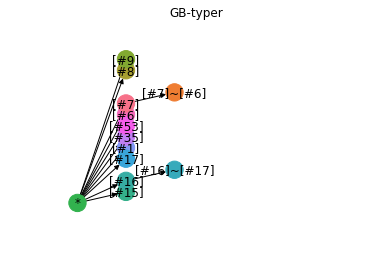

In [44]:
def draw_typing_tree(tree):
    node_color = [color_dict[n] for n in tree.G.nodes()]
    nx.draw_networkx(tree.G, pos=pos_dict, node_color=node_color)
    plt.xlim(-1,max(height_dict.values()) + 2)
    plt.ylim(-1,max(height_dict.values()) + 1)
    #plt.xticks([])
    #plt.yticks([])
    plt.axis('off')
    plt.title('GB-typer')
draw_typing_tree(traj[-1])

In [45]:
def plot_summary(t=1000):
    plt.figure(figsize=(8,8))
    
    # 1. current tree
    ax = plt.subplot(2,2,1)
    tree = traj[t]
    draw_typing_tree(tree)
    
    # 2. radii
    ax = plt.subplot(2,2,2)
    plot_radii(ax, t)
    prettify_axes(ax)

    # 3. log probability
    ax = plt.subplot(2,2,3)
    plot_log_prob(t)
    prettify_axes(ax)
    
    
    # 4. marginal # GB types
    ax = plt.subplot(2,2,4)
    plot_running_average_model_evidence(t)
    prettify_axes(ax)
    
    # (# types trajectory?)
    
    plt.tight_layout()

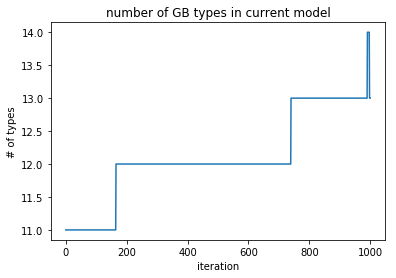

In [46]:
def plot_number_of_atom_types(ax, t=1000):
    ax.plot(n_types)
    ax.set_xlabel('iteration')
    ax.set_ylabel('# of types')
    
    ax.set_title('number of GB types in current model')
ax = plt.subplot(1,1,1)
plot_number_of_atom_types(ax)

In [47]:
dtrees = [tuple(t.nodes) for t in traj]
len(set(dtrees))

4

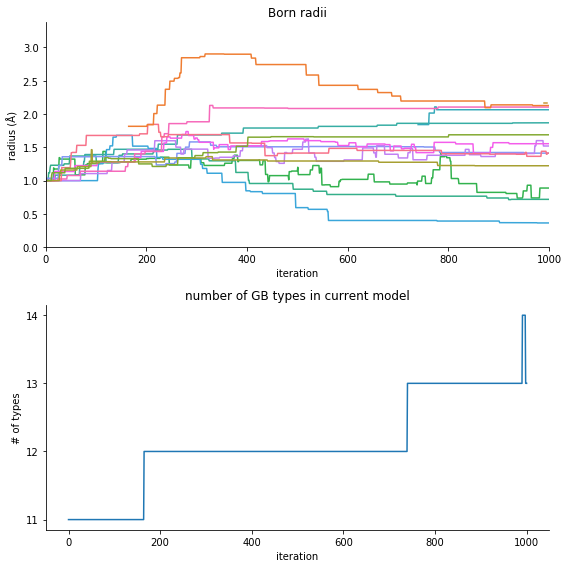

In [161]:
def plot_three_panels(t=1000):
    plt.figure(figsize=(8,8))
    
    ## 1. current tree
    #ax = plt.subplot(2,2,1)
    #tree = traj[t]
    #draw_typing_tree(tree)
    
    # 1. radii
    ax = plt.subplot(2,1,1)
    plot_radii(ax, t)
    prettify_axes(ax)

    ## 2. log probability
    #ax = plt.subplot(3,1,2)
    #plot_log_prob(t, include_number=False)
    #prettify_axes(ax)
    
    # 3. number of atom types
    ax = plt.subplot(2,1,2)
    plot_number_of_atom_types(ax, t)
    plt.yticks(list(range(11, 15)))
    prettify_axes(ax)
    
    
    ## 4. marginal # GB types
    #ax = plt.subplot(2,2,4)
    #plot_running_average_model_evidence(t)
    #prettify_axes(ax)
    
    # (# types trajectory?)
    
    plt.tight_layout()
plot_three_panels()
plt.savefig('three_panels_wo_callouts.png', dpi=300)

In [49]:
np.argmax(n_types)

991

In [50]:
n_types[990:1000]

[13, 14, 14, 14, 14, 14, 14, 14, 13, 13]

In [51]:
n_types[992]

14

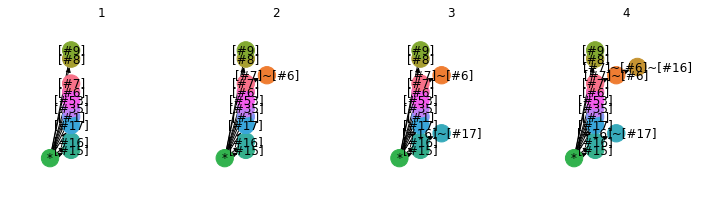

In [150]:
inds_to_plot = [0, 500, 800, 992]

plt.figure(figsize=(3*4,3))

for i, t in enumerate(inds_to_plot):
    plt.subplot(1,4,i + 1)
    draw_typing_tree(traj[t])
    plt.title(i + 1)

plt.savefig('callouts.png', dpi=300)

In [153]:
for t in inds_to_plot:
    print(traj[t])
    print('\n\n')

*          (r = 0.1 nm)
|-[#1]     (r = 0.1 nm)
|-[#6]     (r = 0.1 nm)
|-[#7]     (r = 0.1 nm)
|-[#8]     (r = 0.1 nm)
|-[#9]     (r = 0.1 nm)
|-[#15]    (r = 0.1 nm)
|-[#16]    (r = 0.1 nm)
|-[#17]    (r = 0.1 nm)
|-[#35]    (r = 0.1 nm)
|-[#53]    (r = 0.1 nm)



*                (r = 0.114 nm)
|-[#1]           (r = 0.150 nm)
|-[#6]           (r = 0.208 nm)
|-[#7]           (r = 0.141 nm)
  |-[#7]~[#6]    (r = 0.274 nm)
|-[#8]           (r = 0.129 nm)
|-[#9]           (r = 0.166 nm)
|-[#15]          (r = 0.087 nm)
|-[#16]          (r = 0.179 nm)
|-[#17]          (r = 0.059 nm)
|-[#35]          (r = 0.147 nm)
|-[#53]          (r = 0.162 nm)



*                  (r = 0.134 nm)
|-[#1]             (r = 0.142 nm)
|-[#6]             (r = 0.210 nm)
|-[#7]             (r = 0.140 nm)
  |-[#7]~[#6]      (r = 0.219 nm)
|-[#8]             (r = 0.122 nm)
|-[#9]             (r = 0.165 nm)
|-[#15]            (r = 0.076 nm)
|-[#16]            (r = 0.186 nm)
  |-[#16]~[#17]    (r = 0.206 nm)
|-[#17

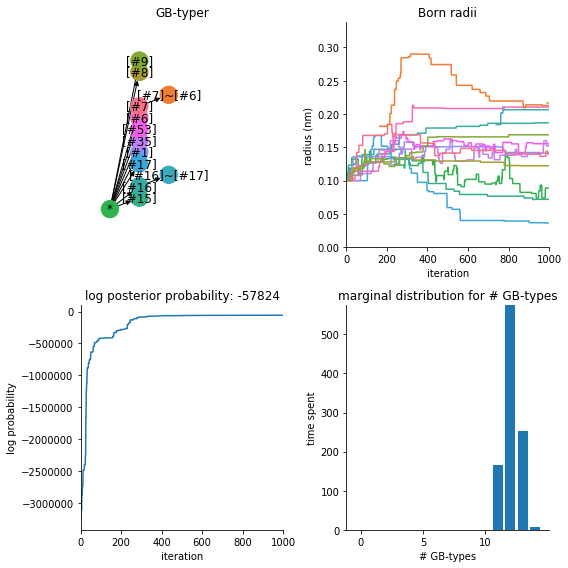

In [53]:
plot_summary(len(traj) - 1)

In [54]:
len(traj)

1001

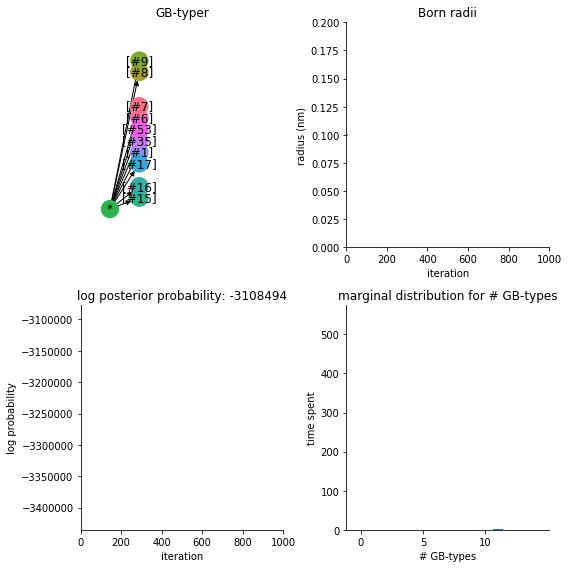

In [55]:
plot_summary(2)

In [56]:
from tqdm import tqdm
for t in tqdm(range(2, len(traj))[::50]):
    plot_summary(t)
    plt.savefig('longer_bugfixed_typing_animation/{:03}.png'.format(t))
    plt.close()

100%|██████████| 20/20 [00:07<00:00,  2.68it/s]


Add subplots for "train" / "test" solvation free energy predictions?

In [57]:
import mdtraj as md
import numpy as np
from pkg_resources import resource_filename
from tqdm import tqdm

from bayes_implicit_solvent.molecule import Molecule
from bayes_implicit_solvent.smarts import atomic_number_dict
from bayes_implicit_solvent.solvation_free_energy import smiles_list
from bayes_implicit_solvent.typers import GBTypingTree
from bayes_implicit_solvent.utils import mdtraj_to_list_of_unitted_snapshots

data_path = '../data/'

np.random.seed(0)
train_mols = []

N_train = 64

smiles_subset = list(smiles_list)
np.random.shuffle(smiles_subset)
train_smiles_subset = smiles_subset[:N_train]
print('looking at only {} entries from FreeSolv'.format(len(train_smiles_subset)))
n_configuration_samples = 10

for smiles in train_smiles_subset:
    mol = Molecule(smiles, vacuum_samples=[])
    path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                               'vacuum_samples/vacuum_samples_{}.h5'.format(
                                                   mol.mol_index_in_smiles_list))
    vacuum_traj = md.load(path_to_vacuum_samples)
    thinning = int(len(vacuum_traj) / n_configuration_samples)
    mol.vacuum_traj = mdtraj_to_list_of_unitted_snapshots(vacuum_traj[::thinning])
    #print('thinned vacuum_traj from {} to {}'.format(len(vacuum_traj), len(mol.vacuum_traj)))
    train_mols.append(mol)

looking at only 64 entries from FreeSolv


In [96]:
test_smiles_subset = smiles_subset[N_train:]
print(len(test_smiles_subset))

578


In [97]:
test_smiles_subset = smiles_subset[N_train:]
test_mols = []
for smiles in test_smiles_subset:
    mol = Molecule(smiles, vacuum_samples=[])
    path_to_vacuum_samples = resource_filename('bayes_implicit_solvent',
                                               'vacuum_samples/vacuum_samples_{}.h5'.format(
                                                   mol.mol_index_in_smiles_list))
    vacuum_traj = md.load(path_to_vacuum_samples)
    thinning = int(len(vacuum_traj) / n_configuration_samples)
    mol.vacuum_traj = mdtraj_to_list_of_unitted_snapshots(vacuum_traj[::thinning])
    #print('thinned vacuum_traj from {} to {}'.format(len(vacuum_traj), len(mol.vacuum_traj)))
    test_mols.append(mol)

In [98]:
print(len(test_mols))

578


In [99]:
experiment_train = [mol.experimental_value for mol in train_mols]
experiment_unc_train = [mol.experimental_uncertainty for mol in train_mols]

experiment_test = [mol.experimental_value for mol in test_mols]
experiment_unc_test = [mol.experimental_uncertainty for mol in test_mols]

In [121]:
mol.experimental_value

-9.384193495222414

In [102]:
def get_train_predictions(tree):
    preds = []
    for mol in train_mols:
        r = tree.assign_radii(mol.mol)
        s = np.ones(len(r))
        preds.append(mol.predict_solvation_free_energy(r, s))
    return preds
def get_test_predictions(tree):
    preds = []
    for mol in test_mols:
        r = tree.assign_radii(mol.mol)
        s = np.ones(len(r))
        preds.append(mol.predict_solvation_free_energy(r, s))
    return preds

In [79]:
train_predictions = []
for t in tqdm(range(2, len(traj))[::10]):
    tree = traj[t]
    tree.ordered_nodes = tree.nodes
    train_predictions.append(get_train_predictions(tree))

100%|██████████| 100/100 [00:15<00:00,  5.86it/s]


In [163]:
x_ = np.arange(2, len(traj))[::10]

In [103]:
test_predictions = []
for t in tqdm(range(2, len(traj))[::10]):
    tree = traj[t]
    test_predictions.append(get_test_predictions(tree))

100%|██████████| 100/100 [03:57<00:00,  2.44s/it]


In [104]:
y_ = [[p[0] for p in pred] for pred in train_predictions]
y_unc = [[p[1] for p in pred] for pred in train_predictions]

y_test = [[p[0] for p in pred] for pred in test_predictions]
y_unc_test = [[p[1] for p in pred] for pred in test_predictions]

In [105]:
np.array(y_test).shape

(100, 578)

In [106]:
np.array(y_).shape

(100, 64)

In [107]:
np.array(experiment_train).shape

(64,)

In [ ]:
from bayes_implicit_solvent.utils import remove_top_right_spines

In [132]:
all_elements = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]
element_dict = dict(zip(all_elements, list(range(len(all_elements)))))

# default radii are 0.15
initial_radius_dict = {}
for atomic_number in all_elements:
    initial_radius_dict[atomic_number] = 0.15

# a few elements have different radii in the default model
# https://github.com/pandegroup/openmm/blob/master/wrappers/python/simtk/openmm/app/internal/customgbforces.py#L233-L257
initial_radius_dict[1] = 0.12
initial_radius_dict[6] = 0.17
initial_radius_dict[7] = 0.155
initial_radius_dict[14] = 0.21
initial_radius_dict[15] = 0.185
initial_radius_dict[16] = 0.18

initial_radii = np.array([initial_radius_dict[a] for a in all_elements])

# scales
initial_scale_dict = {}
for atomic_number in all_elements:
    initial_scale_dict[atomic_number] = 0.8

# a few elements have different radii in the default model
# https://github.com/pandegroup/openmm/blob/master/wrappers/python/simtk/openmm/app/internal/customgbforces.py#L233-L257
initial_scale_dict[1] = 0.85
initial_scale_dict[6] = 0.72
initial_scale_dict[7] = 0.79
initial_scale_dict[8] = 0.85
initial_scale_dict[9] = 0.88
initial_scale_dict[15] = 0.86
initial_scale_dict[16] = 0.96

initial_scales = np.array([initial_scale_dict[a] for a in all_elements])


def pack(radii, scales):
    n = len(radii)
    theta = np.zeros(2 * n)
    theta[:n] = radii
    theta[n:2 * n] = scales
    return theta


def unpack(theta):
    n = int((len(theta)) / 2)
    radii, scales = theta[:n], theta[n:2 * n]
    return radii, scales


initial_theta = pack(initial_radii, initial_scales)

def construct_array(mol, theta):
    radii, scales = unpack(theta)
    
    elements = np.array([a.element.atomic_number for a in mol.top.atoms()])

    mol_radii = np.array([radii[element_dict[element]] for element in elements])
    mol_scales = np.array([scales[element_dict[element]] for element in elements])
    return mol_radii, mol_scales

mol = train_mols[0]
r, s = construct_array(mol, initial_theta)

In [133]:
mol.predict_solvation_free_energy(r, s)

(-14.655308048333747, 0.2988420506416079)

In [135]:
all_mols = train_mols + test_mols
len(all_mols)

642

In [256]:
from bayes_implicit_solvent.constants import beta
def reduce(value):
    """Input value is in units of kcal/mol, turn it into units of kB T"""
    return beta * (value * unit.kilocalorie_per_mole)
    
def unreduce(value):
    """Input value is in units of kB T, turn it into units of kilocalorie_per_mole"""
    return value / (beta * unit.kilocalorie_per_mole)
    
    

In [309]:
obc2_all_preds = []
all_expt_values = []
all_expt_uncs = []

problematic_smiles = []

for mol in all_mols:
    r, s = construct_array(mol, initial_theta)
    pred = unreduce(mol.predict_solvation_free_energy(r, s)[0])
    obc2_all_preds.append(pred)

    all_expt_values.append(unreduce(mol.experimental_value))
    all_expt_uncs.append(unreduce(mol.experimental_uncertainty))
    
    if pred < -30:
        problematic_smiles.append(mol.smiles)

In [313]:
c = np.zeros(len(all_expt_uncs))
for i in range(len(all_expt_uncs)):
    if np.isclose(all_expt_uncs[i], 1.9):
        c[i] = 1
sum(c)

1.0

In [320]:
c = np.zeros(len(all_expt_uncs))
for i in range(len(all_expt_uncs)):
    if all_expt_uncs[i] >= 1.9:
        c[i] = 1
sum(c)

17.0

In [335]:
mol = all_mols[0]
subsearch_string = '[#16]~[#17]'

In [342]:
from bayes_implicit_solvent.utils import cached_substructure_matches
for mol in all_mols:
    if sum(cached_substructure_matches(mol.mol, subsearch_string)) > 0:
        print(mol.smiles)
        print(unreduce(mol.experimental_value))
        print(unreduce(mol.experimental_uncertainty))

CS(=O)(=O)Cl
-4.87
0.6000000000000001


In [306]:
print(problematic_smiles)

['CN(C)C', 'C1COCCN1', 'CNC', 'CC(C)NC(C)C', 'C[C@@H](c1ccc2cc(ccc2c1)OC)C(=O)O', 'CN', 'CC(=O)Oc1ccccc1C(=O)O', 'C1CNCCN1', 'CCCCC(=O)O', 'CCCCCN', 'CCC(=O)O', 'c1ccc(c(c1)[N+](=O)[O-])O', 'CN1CCCCC1', 'C1CCNCC1', 'CC(C)CC(=O)O', 'CCCCCCCCN', 'CN1CCN(CC1)C', 'CCCCN', 'C[C@@H](c1ccc(cc1)CC(C)C)C(=O)O', 'CCN(CC)CC', 'CN(C)CCC=C1c2ccccc2CCc3c1cccc3', 'C1CCC(CC1)N', 'CN(C)CCOC(c1ccccc1)c2ccccc2', 'CCCN', 'COc1c(ccc(c1C(=O)O)Cl)Cl', 'c1ccc(cc1)S', 'c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)O)N', 'CCN', 'CCCCCCCN', 'CN1CCNCC1', 'CC(=O)O', 'C[C@@H](c1ccc(c(c1)F)c2ccccc2)C(=O)O', 'CCNCC', 'c1cc(ccc1[N+](=O)[O-])O', 'CCCC(=O)O', 'C[C@@H](c1cccc(c1)C(=O)c2ccccc2)C(=O)O', 'CCCCCC(=O)O', 'COCCN', 'Cc1cccc(c1C)Nc2ccccc2C(=O)O', 'CC[C@@H](C)c1cc(cc(c1O)[N+](=O)[O-])[N+](=O)[O-]', 'C1CCNC1', 'c1cc(c(cc1c2ccc(cc2F)F)C(=O)O)O', 'c1cc(ccc1C#N)O', 'CCCCCCN', 'CN1CCOCC1', 'CCCNCCC', 'CCCCNCCCC', 'C1CNC1']


In [259]:
diag = np.array(sorted(np.hstack((obc2_all_preds, all_expt_values))))
diag = diag[diag > -30]
min(diag)

-59.59549765875604

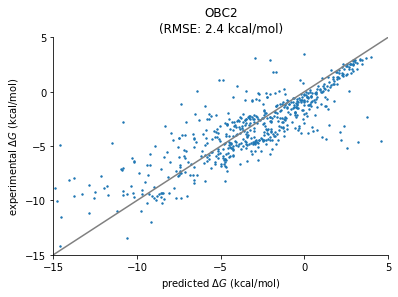

In [323]:
def obc2_scatter_no_error_bars(ax, restrict_range=True, color_by_uncertainty=False):
    
    if color_by_uncertainty:
        ax.scatter(obc2_all_preds, all_expt_values, s=2, c=all_expt_uncs)
    else:
        ax.scatter(obc2_all_preds, all_expt_values, s=2)
    
    ax.plot(diag, diag, color='grey')
    ax.set_xlabel(r'predicted $\Delta G$ (kcal/mol)')
    ax.set_ylabel(r'experimental $\Delta G$ (kcal/mol)')
    
    
    if restrict_range:
        ax.set_xlim(-15,5)
        ax.set_ylim(-15,5)
        ax.set_xticks(list(range(-15,6,5)))
        ax.set_yticks(list(range(-15,6,5)))

    ax.set_title('OBC2\n(RMSE: 2.4 kcal/mol)')
    remove_top_right_spines(ax)
    
    
ax = plt.subplot(1,1,1)
obc2_scatter_no_error_bars(ax)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

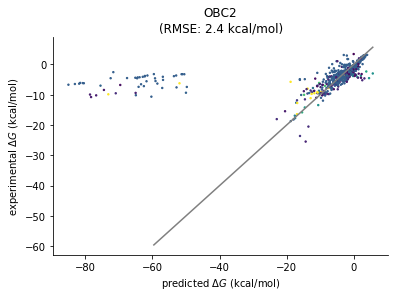

In [331]:
plt.figure()
ax = plt.subplot(1,1,1)
obc2_scatter_no_error_bars(ax, restrict_range=False, color_by_uncertainty=True)
plt.colorbar()

In [268]:
inds = np.array(obc2_all_preds) >-40
obc2_rmse_excluding_outliers = np.sqrt(np.mean((np.array(obc2_all_preds)[inds] - np.array(all_expt_values)[inds])**2))
obc2_rmse_excluding_outliers

2.399490775541891

In [264]:
obc2_rmse = np.sqrt(np.mean((np.array(obc2_all_preds) - np.array(all_expt_values))**2))
obc2_rmse

16.469359572389255

/Users/joshuafass/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


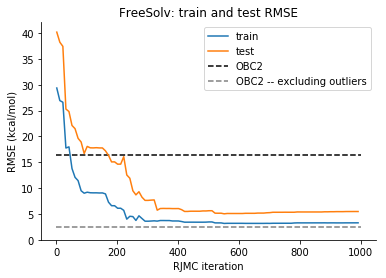

In [270]:
ax = plt.subplot(111)
from bayes_implicit_solvent.utils import remove_top_right_spines

def plot_rmse_train_test(ax):
    ax.hlines(obc2_rmse, xmin=x[0], xmax=x[-1], linestyles='--', label='OBC2')
    ax.hlines(obc2_rmse_excluding_outliers, xmin=x[0], xmax=x[-1], linestyles='--', color='grey', label='OBC2 -- excluding outliers')
    ax.plot(x_, np.sqrt(np.mean((unreduce(np.array(y_) - np.array(experiment_train))**2), axis=1)), label='train')
    ax.plot(x_, np.sqrt(np.mean((unreduce(np.array(y_test) - np.array(experiment_test))**2), axis=1)), label='test')
    ax.set_ylim(0,)


    ax.legend()
    ax.set_ylabel(r'RMSE (kcal/mol)')
    ax.set_xlabel('RJMC iteration')

    ax.set_title('FreeSolv: train and test RMSE')

    remove_top_right_spines(ax)

ax = plt.subplot(1,1,1)
plot_rmse_train_test(ax)
plt.savefig('train-and-test-rmse-with-obc2-baseline.png', dpi=300)

In [248]:
from simtk import unit
from bayes_implicit_solvent.constants import kB, temperature
kcalmol_over_kT = (1.0 * unit.kilocalorie_per_mole) / (kB * temperature)
kcalmol_over_kT

1.6878045854716568

In [276]:
np.sqrt(np.mean((unreduce(np.array(y_) - np.array(experiment_train)))**2, axis=1))[-1]

3.2841006162541335

In [277]:
np.sqrt(np.mean((unreduce(np.array(y_test) - np.array(experiment_test)))**2, axis=1))[-1]

5.472856412321805

In [242]:
obc2_rmse

27.79706060606012

In [243]:
obc2_rmse_excluding_outliers

4.049871533756547

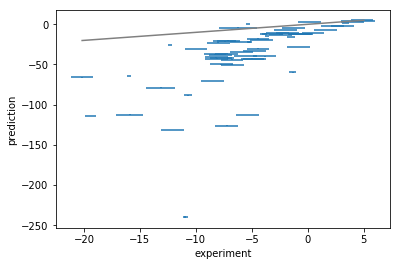

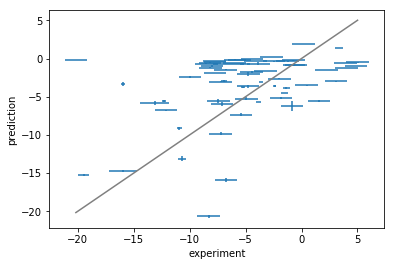

In [81]:
def train_scatter(i=0):
    plt.errorbar(x=experiment_train, xerr=experiment_unc_train, y=y_[i], yerr=y_unc[i], fmt='none')

    plt.plot(sorted(experiment_train), sorted(experiment_train), color='grey')

    plt.xlabel('experiment')
    plt.ylabel('prediction')
    

train_scatter(0)
plt.figure()
train_scatter(-1)

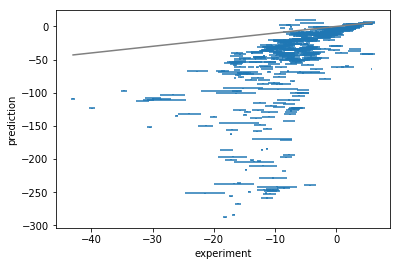

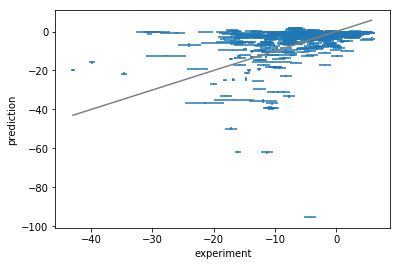

In [169]:
def test_scatter(i=0):
    plt.errorbar(x=experiment_test, xerr=experiment_unc_test, y=y_test[i], yerr=y_unc_test[i], fmt='none')

    plt.plot(sorted(experiment_test), sorted(experiment_test), color='grey')

    plt.xlabel('experiment')
    plt.ylabel('prediction')
    

test_scatter(0)
plt.figure()
test_scatter(-1)

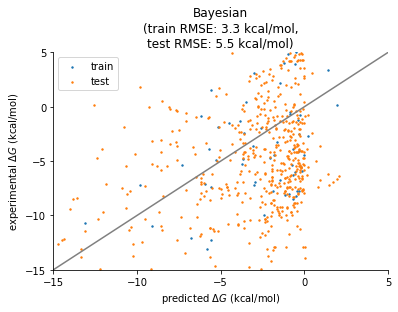

In [296]:
def scatter_no_error_bars(ax, i=0):
    ax.scatter(y_[i], experiment_train, s=2, label='train')
    ax.scatter(y_test[i], experiment_test, s=2, label='test')
    
    plt.legend()

    ax.plot(diag, diag, color='grey')
    plt.xlim(-15,5)
    plt.ylim(-15,5)
    
    ax.set_xticks(list(range(-15,6,5)))
    ax.set_yticks(list(range(-15,6,5)))
    
    ax.set_xlabel('predicted $\Delta G$ (kcal/mol)')
    ax.set_ylabel(r'experimental $\Delta G$ (kcal/mol)')
    
    ax.set_title('Bayesian\n(train RMSE: 3.3 kcal/mol,\ntest RMSE: 5.5 kcal/mol)')
    
    remove_top_right_spines(ax)
ax = plt.subplot(111)
scatter_no_error_bars(ax, i=-1)

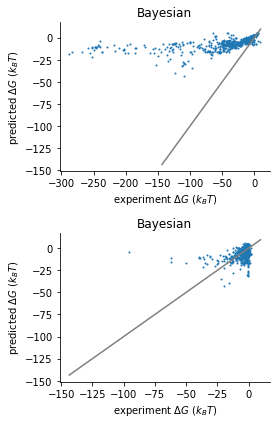

In [237]:
plt.figure(figsize=(4,6))

ax = plt.subplot(2,1,1)
scatter_no_error_bars(ax, i=0)

ax = plt.subplot(2,1,2)
scatter_no_error_bars(ax, i=-1)

plt.tight_layout()

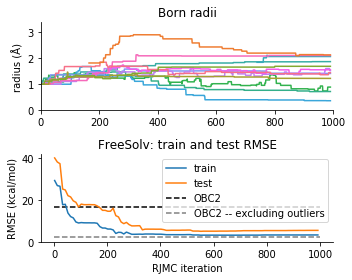

In [301]:
plt.figure(figsize=(5,4))
ax = plt.subplot(2,1,1)
plot_radii(ax, t)
plt.xlabel('')
prettify_axes(ax)


ax = plt.subplot(2,1,2)
plot_rmse_train_test(ax)


plt.tight_layout()

plt.savefig('two-panels-without-callouts.png', dpi=300)

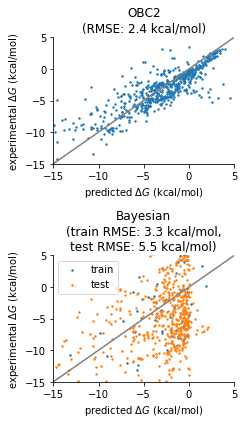

In [297]:
plt.figure(figsize=(3.5,6))

ax = plt.subplot(2,1,1)
obc2_scatter_no_error_bars(ax)

ax = plt.subplot(2,1,2)
scatter_no_error_bars(ax, i=-1)

plt.tight_layout()


plt.savefig('scatter-plots.png', dpi=300)

In [ ]:
test_scatter(-1)

In [ ]:
def train_scatter(i=0):
    plt.errorbar(x=experiment_train, xerr=experiment_unc_train, y=y_[i], yerr=y_unc[i], fmt='none')

    plt.plot(sorted(experiment_train), sorted(experiment_train), color='grey')

    plt.xlabel('experiment')
    plt.ylabel('prediction')
    

train_scatter(0)
plt.figure()
train_scatter(-1)

In [ ]:
plt.errorbar(x=experiment, xerr=experiment_unc, y=y_[-1], yerr=y_unc[-1], fmt='none')

plt.plot(sorted(experiment), sorted(experiment), color='grey')

plt.ylim(min(experiment), max(experiment))
plt.xlabel('experiment')
plt.ylabel('prediction')

In [ ]:
plt.errorbar(x=experiment, xerr=experiment_unc, y=y_[0], yerr=y_unc[0], fmt='none')

plt.plot(sorted(experiment), sorted(experiment), color='grey')

#plt.ylim(min(experiment), max(experiment))
plt.xlabel('experiment')
plt.ylabel('prediction')

In [ ]:
for pred in predictions[::10]:
    plt.figure()
    plt.scatter(experiment, pred)